In [36]:
from scipy.signal import butter, sosfilt_zi, sosfilt
import scipy
import os
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import preprocessing
from scipy.io import loadmat
import seaborn as sns

In [34]:
current_dir = os.getcwd()
os.chdir('c:\\Users\\Melanie\\OneDrive - Rensselaer Polytechnic Institute\\Desktop\\School\\24_Spring\\MLE\\Project\\data')

electrode_locations = {"FP1": 0, "FP2": 1, "FC5": 2, "FC6": 3, "FZ": 4,
                        "T7": 5, "CZ": 6, "T8": 7, "P7": 8, "P3": 9, "PZ": 10,
                          "P4": 11, "P8": 12, "O1": 13, "Oz": 14, "O2": 15}

files = os.listdir()

#getting the demographics both gets rid   
demographics = pd.read_csv(files.pop(0),names=["Isman","Age","Fatigue"])
demographics = demographics.drop([7],axis="index")
n = np.shape(demographics)[0]

In [9]:
def extract_segments(participant, sos):
    signal = loadmat(participant)["SIGNAL"].T
    n,m = np.shape(signal)

    booleans = signal[-2:] #get the columns that show where is what

    #getting the starting indices. np.nonzero returns two arrays, one for the values,
    #and the other one for the locations. Using this I can already get the classes
    # and the indices
    indices = np.nonzero(booleans)
    sort_indices = np.argsort(indices[1])

    classes = indices[0][sort_indices]
    indices = indices[1][sort_indices]

    #now making two arrays, one for the section number and the other for the class boolean
    class_bool = np.zeros(m) 
    section_num = np.zeros(m)

    for (s_num,ind),cond in zip(enumerate(indices),classes):
        class_bool[ind:ind+5121] = cond+1
        section_num[ind:ind+5121] = s_num+1
    
    # choosing only the test condition times
    test_indices = np.where(section_num != 0)[0]
    trimmed_signal = signal.T[test_indices].T

    #splitting up the data
    t = np.array(list(range(len(test_indices))))*0.001953125
    signal = trimmed_signal[1:-2]
    
    #get just the signal part of the signal
    signal = signal[1:-2]
    #getting rid of the drift in the data
    # sos = butter(1, 12, 'hp', fs=512, output='sos')
    initial_condition = (sosfilt_zi(sos).T*signal.T[0]).T
    cond = np.expand_dims(initial_condition,axis=0)
    new_s = sosfilt(sos,signal, zi = cond)[0]
    
    #get the new signal
    section_num = section_num[test_indices]
    class_bool = class_bool[test_indices]

    #getting the participant number
    p_number = int(participant.split(".")[0].split("_")[1])
    
    return t, signal, section_num, class_bool, p_number, new_s

In [24]:
sos = butter(1, 20, 'hp', fs=512, output='sos')
pca = PCA(whiten = True, n_components = 0.99) #whiten means making mean = 0, sd = 1
pca_dimensions = np.zeros(len(files))
for i,f in enumerate(files):
    t, s, section_num, class_bool, p_num, new_s = extract_segments(f, sos)
    new_signal = pca.fit_transform(new_s.T)
    pca_dimensions[i] = np.shape(new_signal)[1]

In [35]:
demographics["99% Variance Dimensions"] = pca_dimensions

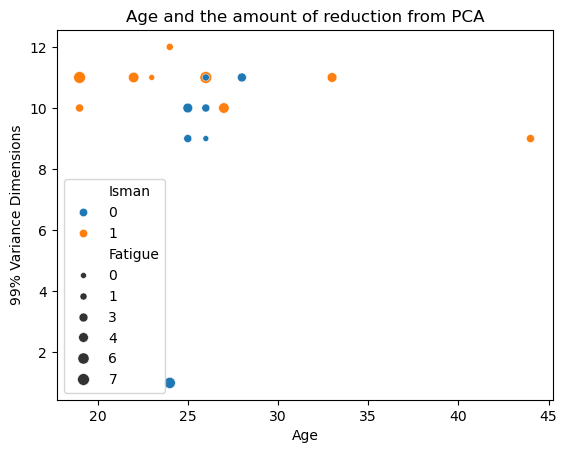

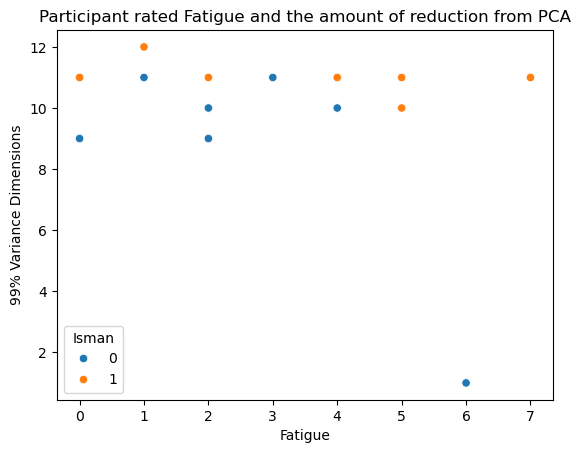

In [37]:
sns.scatterplot(x="Age", y="99% Variance Dimensions", data = demographics, hue='Isman', size = "Fatigue")
plt.title("Age and the amount of reduction from PCA")
plt.show()

sns.scatterplot(x="Fatigue", y="99% Variance Dimensions", data = demographics, hue='Isman')
plt.title("Participant rated Fatigue and the amount of reduction from PCA")
plt.show()